# FlowerML

The goal of this project is to implement the given Tensorflow [tutorial](https://www.tensorflow.org/tutorials/images/classification) and iteratively improve on the CNN model used for image classification/identification. We can document the improvements and assess at each step to see how different methods can lead to more efficient models.

The dataset and model are focused around identifying one of the following classes of flowers, based on the provided input image: [daisy, dandelion, roses, sunflowers, tulips]. The model is initially trained off of the provided [dataset](https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz).

The purpose of this notebook is to provide an 'experimental' environment to assess these model changes and performance, before utilizing the models and techniques in an actual application.

In [1]:
""" Importing the necessary libraries to be used throughout the notebook
    Assinging values to relevant constants to be used
"""

import os

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

print(f"Tensorflow Version: ", tf.__version__)
print(f"Numpy Version: ", np.__version__)
print(f"Pillow Version: ", PIL.__version__)

# We will be formatting our images into such a height/width
IMAGE_HEIGHT = 180
IMAGE_WIDTH = 180

# For buffered prefetching to fetch data without I/O blocking
AUTOTUNE = tf.data.AUTOTUNE

# Batch size
BATCH_SIZE = 32

Tensorflow Version:  2.17.0
Numpy Version:  1.26.4
Pillow Version:  10.4.0


In [2]:
# Downloading the dataset from the URL

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
get_data = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data = pathlib.Path(get_data).with_suffix('')
print(f"Location of data -> {data}")

Location of data -> C:\Users\Zain\.keras\datasets\flower_photos


Total # of images: 3670
Classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


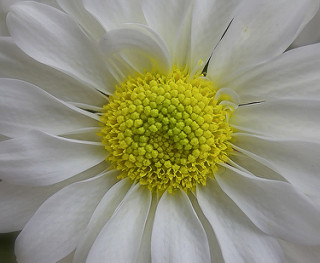

In [3]:
# Peek at the data to confirm

image_count = len(list(data.glob('*/*.jpg'))) # All in JPG format, within all subfolders (classes)
class_names = [x[1] for x in os.walk(data)][0] # List of all subdirs, therefore classes

print(f"Total # of images: {image_count}")
print(f"Classes: {class_names}")

daisy = list(data.glob('daisy/*'))[0] # grab the first daisy image
PIL.Image.open(daisy)

In [4]:
# Alternative custom loading of data (using the tf.data.Dataset)

list_of_files = tf.data.Dataset.list_files(str(data/'*/*'), shuffle=False)
list_of_files = list_of_files.shuffle(image_count, reshuffle_each_iteration=False)

print(len(list_of_files))

3670


In [5]:
# Split the dataset into train/test (80/20)

validation_size = int(image_count * 0.2)
training_set = list_of_files.skip(validation_size)
validation_set = list_of_files.take(validation_size)

print(f"# of images for Training: {len(training_set)}")
print(f"# of images for Validation: {len(validation_set)}")

# of images for Training: 2936
# of images for Validation: 734


In [6]:
# Get the image, label pair from each file path with the image decoded from the file path into a uint8 tensor

def get_image_label(file_path):
    path_parts = tf.strings.split(file_path, os.path.sep) # split the string but keep in tensor notation
    one_hot = path_parts[-2] == class_names
    return tf.argmax(one_hot)

def decode_image(image):
    # Decode image string -> 3D uint8 tensor
    decoded_image = tf.io.decode_jpeg(image, channels=3) # 3 channels for RGB (how would it work for a CMYK format?)
    return tf.image.resize(decoded_image, [IMAGE_HEIGHT, IMAGE_WIDTH]) # resize the image here

def process_image_file_path(file):
    label = get_image_label(file)
    image = decode_image(tf.io.read_file(file))
    return image, label
    
labelled_training_set = training_set.map(process_image_file_path, num_parallel_calls=AUTOTUNE)
labelled_validation_set = validation_set.map(process_image_file_path, num_parallel_calls=AUTOTUNE)

In [7]:
for image, label in labelled_training_set.take(3):
    print(f"Image Shape: {image.numpy().shape} -> Label: {class_names[label.numpy()]} ")

Image Shape: (180, 180, 3) -> Label: tulips 
Image Shape: (180, 180, 3) -> Label: dandelion 
Image Shape: (180, 180, 3) -> Label: sunflowers 


In [8]:
# Configuring the dataset for performance

labelled_training_set = labelled_training_set.cache()
labelled_training_set = labelled_training_set.shuffle(buffer_size=1000)
labelled_training_set = labelled_training_set.batch(BATCH_SIZE)
labelled_training_set = labelled_training_set.prefetch(buffer_size=AUTOTUNE)

labelled_validation_set = labelled_validation_set.cache()
labelled_validation_set = labelled_validation_set.shuffle(buffer_size=1000)
labelled_validation_set = labelled_validation_set.batch(BATCH_SIZE)
labelled_validation_set = labelled_validation_set.prefetch(buffer_size=AUTOTUNE)

In [9]:
# Creating our model

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(class_names))
])

In [10]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,658,565 (6.33 MB)

 Trainable params: 1,658,565 (6.33 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Now we fit the model
# Consider coding the training loop:
# https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch 

model_fit = model.fit(
    labelled_training_set,
    validation_data=labelled_validation_set,
    epochs=5
)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 163ms/step - accuracy: 0.3179 - loss: 1.5191 - val_accuracy: 0.5341 - val_loss: 1.2085
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 0.5667 - loss: 1.0657 - val_accuracy: 0.6144 - val_loss: 0.9817
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 260ms/step - accuracy: 0.6830 - loss: 0.8350 - val_accuracy: 0.6158 - val_loss: 0.9974
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 30s 328ms/step - accuracy: 0.7610 - loss: 0.6538 - val_accuracy: 0.6267 - val_loss: 1.0557
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 43s 473ms/step - accuracy: 0.8370 - loss: 0.4666 - val_accuracy: 0.6253 - val_loss: 1.1349


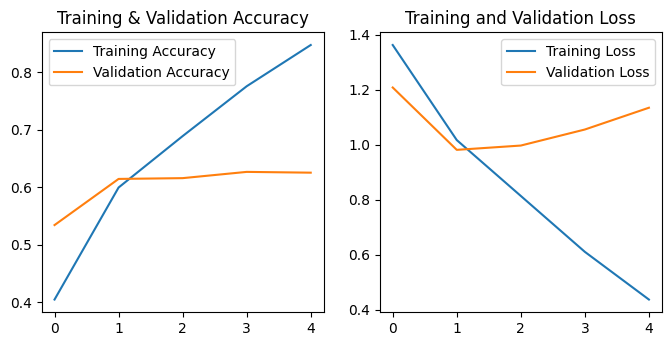

In [12]:
# Plotting our training loss/accuracy

training_accuracy = model_fit.history['accuracy']
validation_accuracy = model_fit.history['val_accuracy']

training_loss = model_fit.history['loss']
validation_loss = model_fit.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.plot(range(len(training_accuracy)), training_accuracy, label="Training Accuracy")
plt.plot(range(len(validation_accuracy)), validation_accuracy, label="Validation Accuracy")
plt.legend(loc='upper left')
plt.title('Training & Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(range(len(training_loss)), training_loss, label="Training Loss")
plt.plot(range(len(validation_loss)), validation_loss, label="Validation Loss")
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [19]:
# Test the model on our test image of a 'tulip'

test_image = tf.keras.utils.load_img('tulip_test.png', target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
test_image_array = tf.keras.utils.img_to_array(test_image)
test_image_array = tf.expand_dims(test_image_array, 0)

prediction = model.predict(test_image_array)
class_prediction = class_names[np.argmax(prediction)]

print(class_prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
roses


We can tell the model could be trained better, the validation accuracy tops at around 0.6 and the loss increases back up during the epochs. We will experiment with different methods to make a more efficient model. This could be due to overfitting with the data.

In [15]:
# Save the model in its current state to be used by Django app.

model.save('flowerMLDJ/models/base_model.h5')

In [17]:
# Load the model and make a prediction with the test image

base_model = tf.keras.models.load_model('flowerMLDJ/models/base_model.keras')
prediction = base_model.predict(test_image_array)
class_prediction = class_names[np.argmax(prediction)]

print(class_prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
roses
